<a href="https://colab.research.google.com/github/soerenml/p1/blob/master/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [1]:
%%capture
pip install yfinance

In [2]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
import matplotlib.pyplot as plt
import yfinance as yf

print(f"Tensorflow: {tf.__version__}")

Tensorflow: 2.5.0


# Load and prepare data

## Download data

In [3]:
def get_stock_data(stocks):
  """
  Function to import stock data.
  Args:
    stocks: list of ticker symbols.
  """
  tickerData = yf.Ticker(stocks)
  td = tickerData.history(
      period='1d',
      start='2000-1-1',
      end='2020-1-25'  
  )   
  return td

df = get_stock_data('SPY')
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03,99.392272,99.392272,96.459110,97.506668,8164300,0.0,0
2000-01-04,96.228663,96.584833,93.620244,93.693573,8089800,0.0,0
2000-01-05,93.819273,94.887782,92.017474,93.861176,12177900,0.0,0
2000-01-06,93.609745,94.866815,92.352676,92.352676,6227200,0.0,0
2000-01-07,94.070708,97.716209,93.903098,97.716209,8066500,0.0,0
...,...,...,...,...,...,...,...
2020-01-17,323.497820,323.965932,322.668833,323.741638,95846000,0.0,0
2020-01-21,322.717594,323.965941,322.639585,323.107697,77742400,0.0,0
2020-01-22,324.024406,324.716871,322.980888,323.146667,48914900,0.0,0


## Data preprocessing

In [4]:
# TODO take log check if time is in the right order
def etl(list_variables):
  """
  Function to calculate pct. change.
  Args:
    list_variables = list of variables.
  """
  for i in list_variables:
    new_name = i + '_pct'
    df[new_name] = df[i].pct_change()

etl(['Close', 'Volume'])

df['Buy'] = df['Close_pct'].apply(lambda x: 1 if x >= 0 else 0)

In [5]:
df = df[['Close_pct', 'Volume_pct', 'Close']]
df.dropna() # drop missing values
print(df)

            Close_pct  Volume_pct       Close
Date                                         
2000-01-03        NaN         NaN   97.506668
2000-01-04  -0.039106   -0.009125   93.693573
2000-01-05   0.001789    0.505340   93.861176
2000-01-06  -0.016072   -0.488647   92.352676
2000-01-07   0.058077    0.295365   97.716209
...               ...         ...         ...
2020-01-17   0.003113    0.773274  323.741638
2020-01-21  -0.001958   -0.188882  323.107697
2020-01-22   0.000121   -0.370808  323.146667
2020-01-23   0.001147    0.062314  323.517273
2020-01-24  -0.008893    0.685399  320.640198

[5047 rows x 3 columns]


## Plot data

Text(0.5, 1.0, 'Volume_pct')

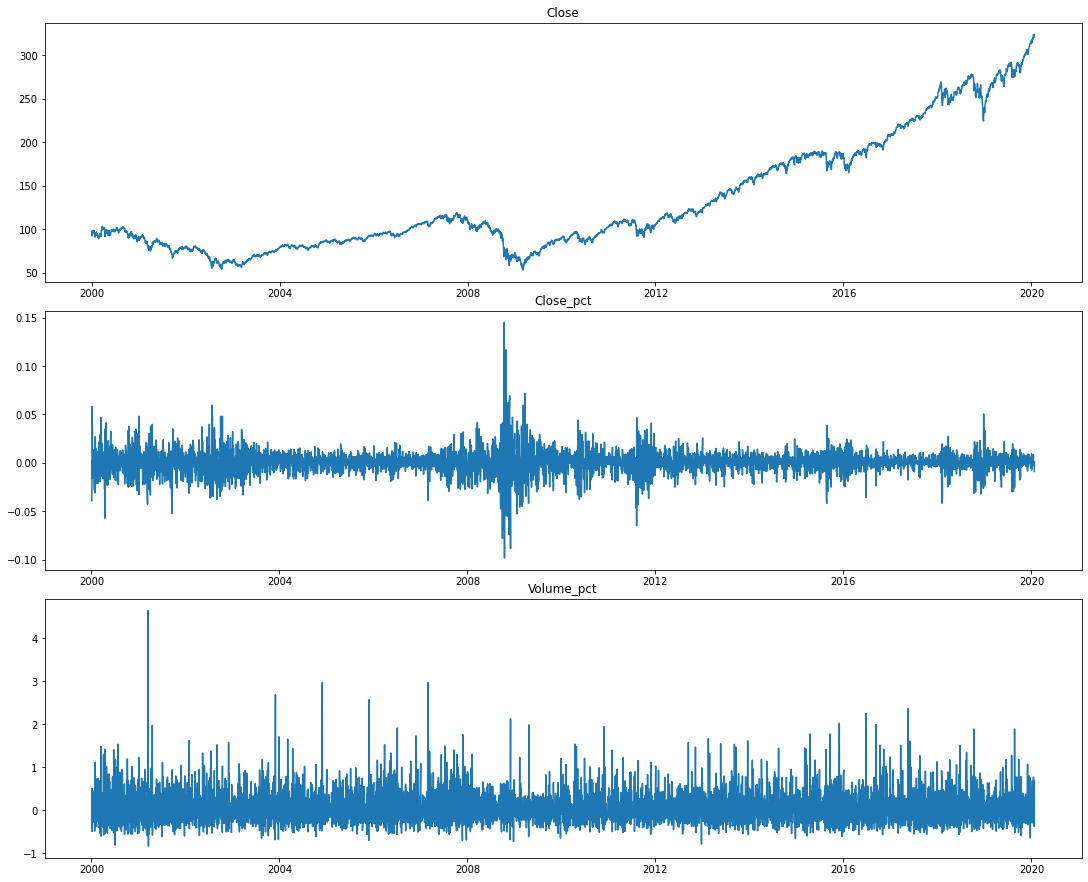

In [6]:
fig = plt.figure(figsize=(18,4))
ax = fig.add_axes([0.1,0.2,0.8,0.9])
ax.plot(df['Close'])
ax.set_title('Close')

ax = fig.add_axes([0.1,-0.8,0.8,0.9])
ax.plot(df['Close_pct'])
ax.set_title('Close_pct')

ax = fig.add_axes([0.1,-1.8,0.8,0.9])
ax.plot(df['Volume_pct'])
ax.set_title('Volume_pct')

### Create date sets

In [8]:
def create_datasets(train_size, test_size):
  """
  Args:
    train_size: obs. training set (%)
    test_size: obs. validation set (%)
  """
  # Create sets
  n = len(df)
  train_df = df[0:int(n*train_size)]
  val_df = df[int(n*train_size):int(n*test_size)]
  test_df = df[int(n*test_size):]
  
  return n, train_df, val_df, test_df

n, train_df, val_df, test_df = create_datasets(0.7, 0.9)

# Create windows

[Example](https://www.tensorflow.org/tutorials/structured_data/images/split_window.png)



In [25]:
class WindowGenerator():
  def __init__(
      self,
      input_width,
      label_width,
      shift,
      label_columns,
      train_df=train_df,
      val_df=val_df,
      test_df=test_df):
    
    
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.label_columns = label_columns
    
    # TODO: understand this part.
    self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Store window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift
    self.input_slice = slice(0, input_width)

    # Return evenly spaced intervals.
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]


  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])
    return inputs, labels


  def make_dataset(self, data):
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds


  def __repr__(self):
    return '\n'.join(
        [
         f'Total window size: {self.total_window_size}\n',
         f'Input indices: {self.input_indices}\n',
         f'Label indices: {self.label_indices}\n',
         f'Label column name(s): {self.label_columns}\n',
         f'Column indices: {self.column_indices}']
    )

@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test

# Train final model

In [26]:
wide_window = WindowGenerator(
    input_width=5,
    label_width=1,
    shift=1,
    label_columns=['Close_pct'])

wide_window

Total window size: 6

Input indices: [0 1 2 3 4]

Label indices: [5]

Label column name(s): ['Close_pct']

Column indices: {'Close_pct': 0, 'Volume_pct': 1, 'Close': 2}

In [27]:
print(wide_window.train.element_spec)

w1 = wide_window.train
[(features, label)] = w1.take(1)
print(features[0,:,:])

(TensorSpec(shape=(None, 5, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))
tf.Tensor(
[[ 1.14214888e-02 -3.75501604e-01  8.82873917e+01]
 [ 5.11060961e-03 -2.29533642e-01  8.87385941e+01]
 [ 2.62424723e-03  4.39298587e-02  8.89714661e+01]
 [ 1.39053864e-03 -2.06064649e-01  8.90951843e+01]
 [ 3.92014512e-03  5.45294945e-01  8.94444504e+01]], shape=(5, 3), dtype=float64)


In [28]:
# Check tensor dimension input data.
wide_window.train

<MapDataset shapes: ((None, 5, 3), (None, 1, 1)), types: (tf.float64, tf.float64)>

In [29]:
inputs = tf.keras.Input(shape=(5, 3))
ls_1 = tf.keras.layers.LSTM(3, return_sequences=True)(inputs)
outputs = tf.keras.layers.Dense(units=1)(ls_1)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="lstm")
model.summary()
inputs

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 5, 3)]            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 3)              84        
_________________________________________________________________
dense_2 (Dense)              (None, 5, 1)              4         
Total params: 88
Trainable params: 88
Non-trainable params: 0
_________________________________________________________________


<KerasTensor: shape=(None, 5, 3) dtype=float32 (created by layer 'input_3')>

In [30]:
from tensorflow.keras.losses import BinaryCrossentropy

def compile_and_fit(model, window):

  model.compile(
      loss=tf.losses.MeanSquaredError(),
      optimizer=tf.optimizers.Adam(),
      metrics=tf.metrics.MeanAbsoluteError())
  
  history = model.fit(
      window.train,
      validation_data=window.val,
      epochs=10)
  
  
  return history

In [31]:
history = compile_and_fit(model, wide_window)

Epoch 1/10
111/111 [==============================] - 3s 9ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 2/10
111/111 [==============================] - 1s 6ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 3/10
111/111 [==============================] - 1s 6ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 4/10
111/111 [==============================] - 1s 6ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 5/10
111/111 [==============================] - 1s 5ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 6/10
111/111 [==============================] - 1s 6ms/step - loss: nan - mean_absolute_error: nan - val_loss: nan - val_mean_absolute_error: nan
Epoch 7/10
111/111 [==============================] - 1s 6ms/step - loss: nan - mean_abs